# Supplementary Information: Holmes *et al.* 2017

# 2. Full model fitting

This notebook describes fitting of a Bayesian hierarchical model of the effects of control (growth) and treatment (passage) on individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load), to data obtained using a multi-*E. coli* microarray.

## Experiment summary and interpretation

The experiment involves measuring changes in microarray probe intensity before and after a pool of bacteria are subjected to one of two processes:

1. a sample from the pool is grown in media to a defined OD, then subsampled. This growth/subsample process is repeated *n* times.
2. a sample from the pool is applied to plant leaves, subsampled, and that subsample grown in media to a defined OD, then subsampled. This passage/growth/subsample process is repeated *n* times

In a single replicate, the microarray is exposed to genomic DNA extracted from the pool (i) before the experiment begins, and (ii) after the experiment concludes. Three replicates were performed.

All genes in all samples go through the *growth* (control) part of the experiment, and we wish to estimate the effect of *passage* (treatment) on individual genes. 

The pool of bacteria comprises isolates of *E. coli* DH10B as a carrier organism. These isolates also contain BACs encoding random stretches of the *E. coli* Sakai chromosome. We therefore expect carrier organism genes to be unaffected by passage (treatment), and for any effects to be detectable only for genes that originate from *E. coli* Sakai.

We expect that genes that confer a selective advantage only for association with the plant should be enriched at the end of the treatment experiment, but not at the end of the control experiment. Sakai genes that are enriched in both treatment and control experiments may be generally advantageous for growth. 

As the BACs describe contiguous regions of the *E. coli* Sakai genome, there is the possibility that linkage disequilibrium could result in some genes that do not confer an advantage by themselves apparently displaying enrichment after treatment.

If the biological function conferring an advantage during passage is encoded by a suite of coregulated genes in an operon, we might expect all members of this suite to show evidence of enrichment after passage. It is likely that clusters of enrichment post-passage will be seen in the results.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We assume that each array probe $i$ measures the quantity of genomic DNA in the sample that corresponds to a single gene $j[i]$. There may be multiple probes relating to a single gene, so it is possible that $j[p] = j[q], p \neq q$.

We define the (input) measurement of a probe before the experiment as $x_i$, and the (output) measurement of that probe after the experiment as $y_i$. We assume that the measurement of each probe is subject to random experimental/measurement error that is normally-distributed with mean zero and variance $\sigma_y^2$. The actual value to be measured after the experiment can then be represented as $\hat{y}$, and the irreducible error in the measurement as $\epsilon$.

$$y \sim N(\hat{y}, \epsilon)$$
$$y_i = \hat{y_i} + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma_y^2)$$

The relationship between the input and (actual) output measurements for a single probe can be represented as $\hat{y_i} = f(x_i)$. That is to say, that the input value $x_i$ for a probe is a *predictor* of the measured output value. This relationship will be modelled as the sum of two linear effects:

$$\textrm{control effect} = \alpha + \beta x$$
$$\textrm{treatment effect} = \gamma + \delta x$$
$$\hat{y_i} = \textrm{control effect}(x_i) + \textrm{treatment effect}(x_i) = \alpha + \beta x_i + \gamma + \delta x_i$$

As these are linear effects, we have intercept/offset parameters ($\alpha$, $\gamma$) and gradient/slope parameters ($\beta$, $\delta$). Where $\beta$ or $\delta$ are large, they would indicate large $x_i$-dependent effects of the control (growth) and treatment (passage) parts of the experiment respectively.

As formulated above, the four parameters are identical for all probes, but we are interested in estimating the effects for individual genes, so we require one set of parameters for each individual gene $j[i]$: $\alpha_{j[i]}$, $\beta_{j[i]}$, $\gamma_{j[i]}$, $\delta_{j[i]}$, and the relationship for each probe is modelled as:

$$\hat{y_i} = \textrm{control effect}_{j[i]}(x_i) + \textrm{treatment effect}_{j[i]}(x_i) = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} + \delta_{j[i]} x_i$$

The parameters $\alpha_{j[i]}$, $\beta_{j[i]}$, $\gamma_{j[i]}$, $\delta_{j[i]}$ (and $\epsilon$) are to be estimated by the model fit. We assume that the values of each parameter are drawn from a single *pooled distribution* for that parameter, for all genes $j[i]$. This ensures that our fits are not completely pooled (which would imply that all parameter estimates are constant for all genes, and would not be informative for our goal to identify gene-level effects), and not completely unpooled (which would allow all parameter estimates to vary independently, and would be equivalent to simultaneously fitting independent linear relationships to each gene). Rather, using a *pooled distribution* allows the parameter estimate for one gene to influence the estimates of that parameter for all other genes in the experiment. We need to define a *prior distribution* for each parameter that constrains the allowable values that can be fit, in each case. We assume that each parameter can be drawn from a parent Cauchy distribution, chosen because it has fat tails and infinite variance so can accommodate outlying and extreme values better than a Normal distribution:

$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$

Each parameter's prior distribution requires a fit of both its mean and variance. We assume that the variance of each parameter's prior can be drawn from a Uniform distribution on the range (0, 100):

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$

We therefore construct the following model of the experiment:

$$y_i = \hat{y_i} + \epsilon_i$$
$$\hat{y_i} = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i$$
$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$
$$\epsilon_i \sim N(0, \sigma_y^2)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 pseudovariable indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: control effect offset for gene $j[i]$
* $\mu_{\alpha}$: mean control effect offset for all genes
* $\sigma_{\alpha}$: control effect offset variance for all genes
* $\beta_{j[i]}$: control effect slope for gene $[j[i]$
* $\mu_{\beta}$: mean control effect slope for all genes
* $\sigma_{\beta}$: control effect slope variance for all genes
* $\gamma_{j[i]}$: treatment effect offset for gene $j[i]$
* $\mu_{\gamma}$: mean treatment effect offset for all genes
* $\sigma_{\gamma}$: treatment effect offset variance for all genes
* $\delta_{j[i]}$: treatment effect slope for gene $j[i]$
* $\mu_{\delta}$: mean treatment effect slope for all genes
* $\sigma_{\delta}$: treatment effect slope variance for all genes
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points
* `J`: `int`, the number of unique locus tags (`J` < `N`)
* `tag`: `int[N]`, an index list of locus tags
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, offset effect on log(intensity) of passing through the experiment for each locus tag/gene
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for all locus tags
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, for each locus tag/gene
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for all locus tags
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset) for each locus tag/gene
* `mu_g`: `real`, an unconstrained value to be fit that represents the mean offset for all locus tags due to *treatment*
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope) for each locus tag/gene
* `mu_d`: `real`, an unconstrained value to be fit that represents the mean slope for all locus tags due to *treatment*
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset for all locus tags
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope for all locus tag
* `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the offset for all locus tags due to *treatment*
* `sigma_d`: `real<lower=0,upper=100>`, standard deviation of the slope for all locus tags due to *treatment*


We also define a `transformed parameter`:

* `y_hat[i] <- b[tag[i]] * x[i] + a[tag[i]] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

### Load input data for fit

In the cells below we load in the data to be fit, and define useful variables for inspecting/analysing the data later:

* `locus_tags`: the unique locus tags represented in the dataset
* `ntags`: the number of unique locus tags
* `outdir`: path to the directory in which to place model fit output
* `outfile`: path to the model fit output file (pickled dataframe)

In [2]:
# load clean, normalised, indexed data
data = pd.read_csv("datasets/normalised_array_data.tab", sep="\t")  # full dataset

# useful values
locus_tags = data['locus_tag'].unique()
ntags = len(locus_tags)

In [3]:
# Create output directory and filename
outdir = "model_fits"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, 'full_model_fit.pkl')

### Define and fit the Stan model

In the cells below we define the model to be fit, in the Stan language, conduct the fit, and save the fit out to a pickled dataframe>

In [4]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> tag[N];
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_b;
  real mu_g;
  real mu_d;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_g;
  real<lower=0,upper=100> sigma_d;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[tag[i]] + b[tag[i]] * x[i] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ cauchy(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ cauchy(mu_b, sigma_b);

  sigma_g ~ uniform(0, 100);
  g ~ cauchy(mu_g, sigma_g);

  sigma_d ~ uniform(0, 100);
  d ~ cauchy(mu_d, sigma_d);

  y ~ normal(y_hat, sigma);
}
"""

In [5]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': ntags,
                       'tag': data['locus_tag_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [6]:
# run stan fit
#treatment_fit = pystan.stan(model_code=treatment_model,
#                            data=treatment_data_dict,
#                            iter=1000, chains=2,
#                            seed=tools.SEED)

In [7]:
# Save model to file, for reuse# Save fit to file, for reuse
#unpermutedChains = treatment_fit.extract()
#unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
#pickle.dump(unpermutedChains_df, open(outfile, 'wb'))

### Extract the fit

In the cells below we load in the contents of the pickled output (if the fit has already been run), and then extract useful summary information about mean, median, variance, and credibility intervals for the parameter estimates.

In [8]:
# Uncomment the line below to import a previously-fit model
treatment_fit = pickle.load(open(outfile, 'rb'))

In [9]:
# Get summary data for parameter estimates
# use 'fit' for the model fit directly, and 'df'for loaded pickled data
estimates = tools.extract_variable_summaries(treatment_fit, 'df', locus_tags)
estimates.head()

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.029129,0.244940,0.332219,0.426666,0.276330,0.295267,0.097412,0.918105,0.937876,...,0.373606,0.386956,0.091973,-0.090580,-0.062259,-0.055452,-0.036866,-0.059451,-0.058879,0.011430
4705,ECDH10B_RS00020,0.169773,0.272327,0.336390,0.427064,0.303134,0.305796,0.060675,0.923711,0.938501,...,0.385294,0.391275,0.064762,-0.079569,-0.062273,-0.054959,-0.044358,-0.059307,-0.058405,0.008574
5475,ECDH10B_RS00060,0.092371,0.268534,0.338677,0.493763,0.297471,0.307758,0.099552,0.916767,0.938826,...,0.383268,0.389446,0.073516,-0.089941,-0.063986,-0.055564,-0.036741,-0.060844,-0.059464,0.012340
5474,ECDH10B_RS00065,0.091092,0.258078,0.334934,0.449760,0.294165,0.302821,0.081867,0.907745,0.938434,...,0.385307,0.391122,0.106802,-0.090234,-0.062454,-0.054761,-0.040138,-0.059514,-0.058488,0.011435
5469,ECDH10B_RS00070,0.083468,0.265716,0.334018,0.413204,0.291290,0.301167,0.073938,0.918311,0.938084,...,0.373458,0.389639,0.107962,-0.130703,-0.067450,-0.056503,-0.047106,-0.068497,-0.059957,0.022810


In [10]:
# Separate estimates for Sakai and DH10B
sakai_estimates = tools.split_estimates(estimates, 'sakai')
dh10b_estimates = tools.split_estimates(estimates, 'dh10b')

## Inspecting the fit

In the cells below, we visualise the fitted estimates for each of the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ as:

* box plots of median estimates for each locus tag
* relationship between control and treatment effects in Sakai
* plots of 95% credibility interval range against median estimate for each locus tag

### Median parameter estimates

We first inspect the range of fitted estimates to get an overview of the relationships for the data as a whole, and then examine whether this relationship varies by *E. coli* isolate.

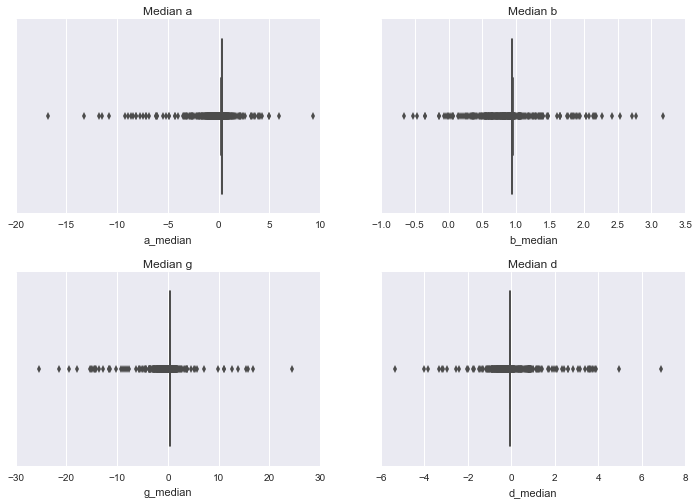

In [11]:
# Visualise median values for parameter estimates
tools.boxplot_medians(estimates)

For this fit we can see that most median values of $\alpha$ (control intercept), $\gamma$ (treatment intercept), and $\delta$ (treatment slope) are close to zero. Most values of $\beta$ are close to (but slightly less than) unity. This implies that:

* The linear relationship between input and output intensity due to the control effects (growth only) is, for most genes in the experiment, a slight reduction of output intensity with respect to input intensity value [median $\alpha$ ≈ 0, median $\beta$ ≈ 1]
* For most genes in the experiment there is no treatment effect due to exposure to the plant [median $\gamma$ ≈ 0, median $\delta$ ≈ 0]

There are, however, a considerable number of outlying median values for each parameter, which suggests that a number of genes have associated parameter values that are affected by either control (growth) or treatment (passage).

#### DH10B

Considering the Sakai estimates only:

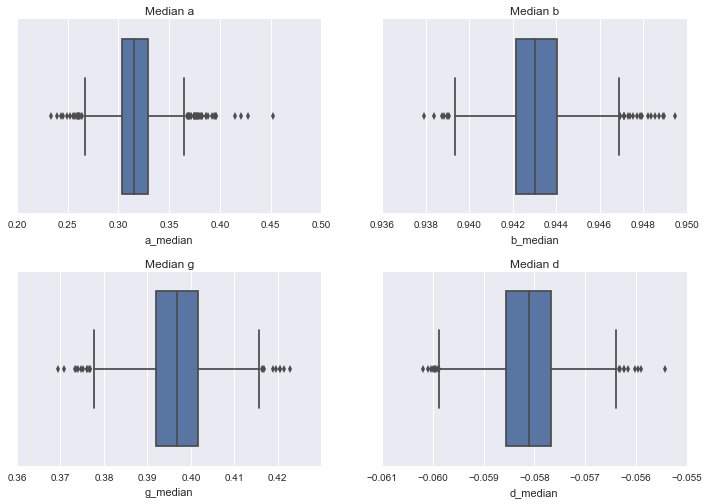

In [12]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(dh10b_estimates)

#### Sakai

Considering the Sakai estimates only:

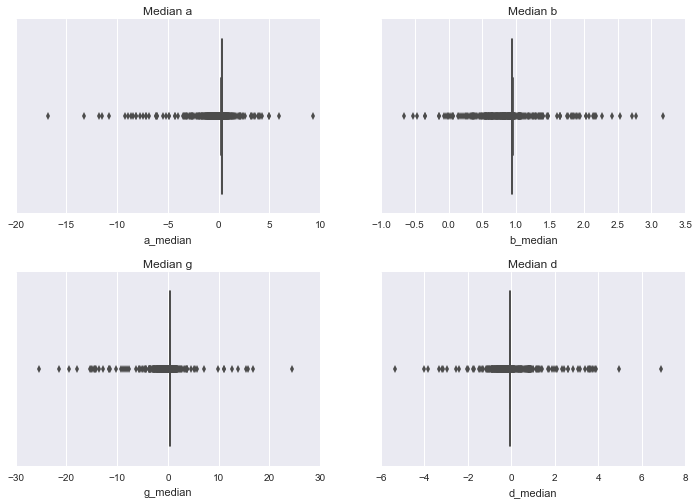

In [13]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(sakai_estimates)

From these boxplots it is clear that the median parameter estimates for DH10B are extremely restricted in their range:

* $0.2 < \alpha < 0.5$
* $0.936 < \beta < 0.95$
* $0.36 < \gamma < 0.43$
* $-0.061 < \delta < 0.06$

As before the control effect appears to be essentially neutral, in that the output intensity is almost a 1:1 linear relationship with the input intensity, but it is striking that the median estimates of $\gamma$ and $\delta$ are very close to zero, suggesting that passage (treatment) has almost no effect on this relationship, for any DH10B locus tag.

This is exactly what would be expected for DH10B as the carrier isolate.

By contrast, the median parameter estimates for Sakai are extremely variable, though the bulk of estimates are close to the values seen for DH10B:

* $-20 < \alpha < 10$
* $-1 < \beta < 3.5$
* $-30 < \gamma < 30$
* $-6 < \delta < 8$

This indicates the expected result, that strong variability of control and treatment effects are effectively confined to the Sakai BAC fragments.

It is expected that some genes/operons may be relatively advantageous in either growth (control) or passage (treatment) conditions, or both. We can visualise the relationships between parameter estimates for control and treatment effects in scatterplots.

In [14]:
def plot_treatment_vs_control(df):
    """Plot median treatment vs control parameters in a 2x2 matrix"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()
    fig.subplots_adjust(hspace=0.3)
    
    for idx, xvar, yvar, ax in zip(range(4),
                                   ['a_median', 'a_median',
                                    'b_median', 'b_median'],
                                   ['g_median', 'd_median',
                                    'g_median', 'd_median'],
                                   axes):
        ax.scatter(df[xvar], df[yvar], alpha=0.2)
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)

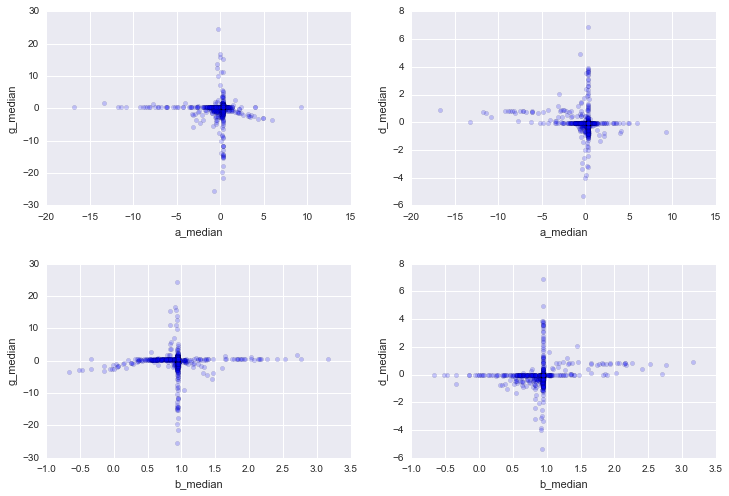

In [15]:
# Plot estimated parameters for treatment effects against control effects for Sakai
plot_treatment_vs_control(sakai_estimates)

The strong cross-like distributions indicate that most parameter estimates that vary from those of the bulk are orthogonal: deviation of the control experiment parameters is not associated with deviation of the treatment effect parameters.

However, there is a group of estimates in the plots of `d_median` against `a_median` and `b_median` that suggest an additional effect is in play. Several locus tags with median estimates of $\delta \approx 1$ are also associated with large values of `b_median`. This might reflect a situation where the variability in the estimates of $\beta$ and $\delta$ is large, and the uncertainty is being partitioned across the two parameters, or it could indicate that there is genuinely a strong positive effect on the BAC-carrying organisms under both conditions.

We can inspect this group of locus tags directly, to examine whether the 95% credibility intervals for those parameter estimates include 1 (for $\beta$) or 0 (for $\delta$). If that is the case for both estimates on a locus tag, then we might consider that the median estimates are the result of partitioning variability across both estimates.

In [16]:
# Extract the suspect locus tags, which have large estimates for d_median and b_median
suspects = sakai_estimates.loc[(sakai_estimates['b_median'] > 1) &
                               (sakai_estimates['d_median'] > 0.5)]
suspects = suspects[['locus_tag',
                     'b_median', 'b_2.5pc', 'b_97.5pc',
                     'd_median', 'd_2.5pc', 'd_97.5pc']]
suspects

,locus_tag,b_median,b_2.5pc,b_97.5pc,d_median,d_2.5pc,d_97.5pc
2992,ECs0218,2.177616,1.648019,2.656389,0.696648,0.212189,1.158068
4460,ECs0237,1.173647,0.795524,2.199794,0.547856,-0.064777,2.297449
1021,ECs1357,2.531182,1.957337,3.062126,0.732440,0.409551,1.048997
4768,ECs1556,1.330507,0.882774,2.302321,0.812953,0.216107,2.266111
163,ECs1557,3.166764,2.772861,3.590428,0.891258,0.679918,1.240506
915,ECs3222,2.768258,2.434587,3.095956,0.658634,0.426298,0.869889
886,ECs3232,1.035740,0.934710,1.115305,1.664662,1.193798,2.156372
875,ECs3233,1.318883,0.935725,2.206321,0.771997,-0.062680,2.113179
627,ECs3239,1.380284,0.939670,2.222052,0.804196,-0.065722,2.274725
615,ECs3242,1.469263,0.939575,2.401819,0.881952,0.117384,2.169571


From the table that results, only a few locus tags have parameter estimate variability that suggests it could take the value of the bulk of the population:

* ECs0237
* ECs3233
* ECs3239

Otherwise the 95% CI for each of the parameter estimates suggests we should have some confidence in their values being unusually high for both control and treatment effects, so potentially being genes that confer a general, and not specifically plant-associated advantage on the carrier isolate.

## Identifying locus tags that confer an advantage under treatment and/or control

We use a 50% credibility interval to determine whether the effect of a gene on passage is likely to be positive. Under this assumption, the middle 50% of the parameter estimates for $\delta$ do not include zero. We label these `trt_pos`.

Likewise, we use a 50% credibility interval to determine whether the effect of a gene on surviving growth (control) is an outlier. If the 50% CI for $\beta$ does not include the 97.5 percentile for all estimates of $\beta$ in this dataset, we consider that the effect of the gene on surviving growth conditions is positive. We label these `ctl_pos`.

We create a third category: `combined`: genes with a positive effect on both growth and passage.

In [17]:
# Label locus tags with positive effects
sakai_estimates = tools.label_positive_effects(sakai_estimates)

We can count the number of locus_tags in each of the groups:

In [18]:
# Count locus tags in each of the positive groups
counts = [sum(sakai_estimates[col]) for col in ('trt_pos', 'ctl_pos', 'combined')]
print("treatment positive: {0}\ncontrol positive: {1}\nboth: {2}".format(*counts))

treatment positive: 72
control positive: 52
both: 24


which indicates, with these assumptions, that 72 genes have a positive effect on passage (treatment), 24 of these also have a positive effect in the growth (control) step, and a further 28 have a positive effect only on the growth step.

### Plotting distribution of effects

We can show the estimated effects, and our confidence in those estimates, on a rough representation of the genome by plotting those values for each locus tag in genome order.

In the plots that follow, parameter estimates for each locus tag are rendered as points (the median estimate), with the 50% credibility interval for the estimate indicated as a line. If the 50% CI includes a threshold value - either the median value for the parameter estimate ($\beta$) or zero ($\delta$) - then it is not of interest to us as there is not good evidence of an effect due to that gene, and the interval is coloured blue.

If the interval does not include the corresponding threshold value, then it is coloured either green for a positive effect, or red for a negative effect.

#### Sakai

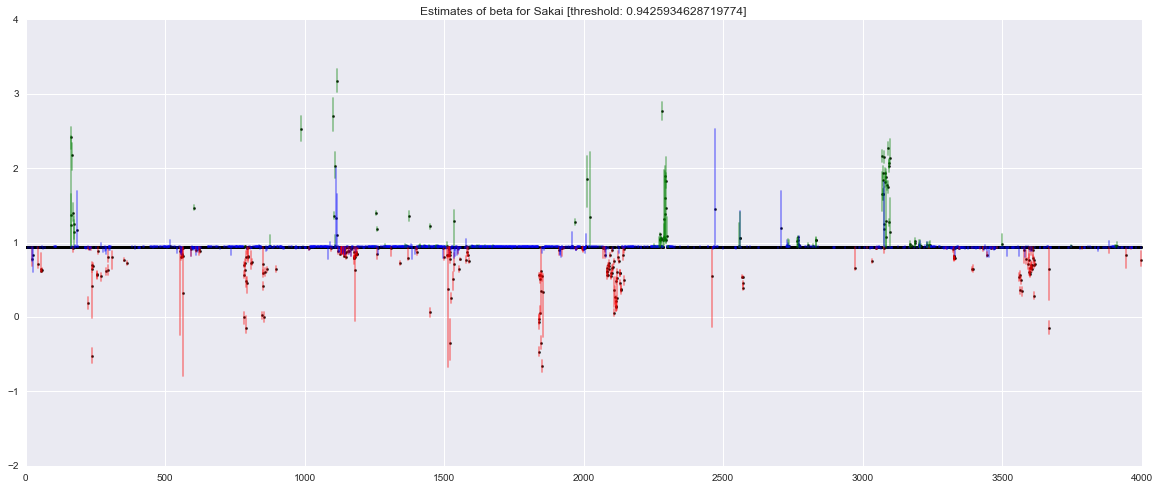

In [19]:
# Plot genome-wide estimates of beta for Sakai
beta_thresh = np.median(sakai_estimates['b_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(sakai_estimates, 'b', 'Estimates of beta for Sakai', beta_thresh)

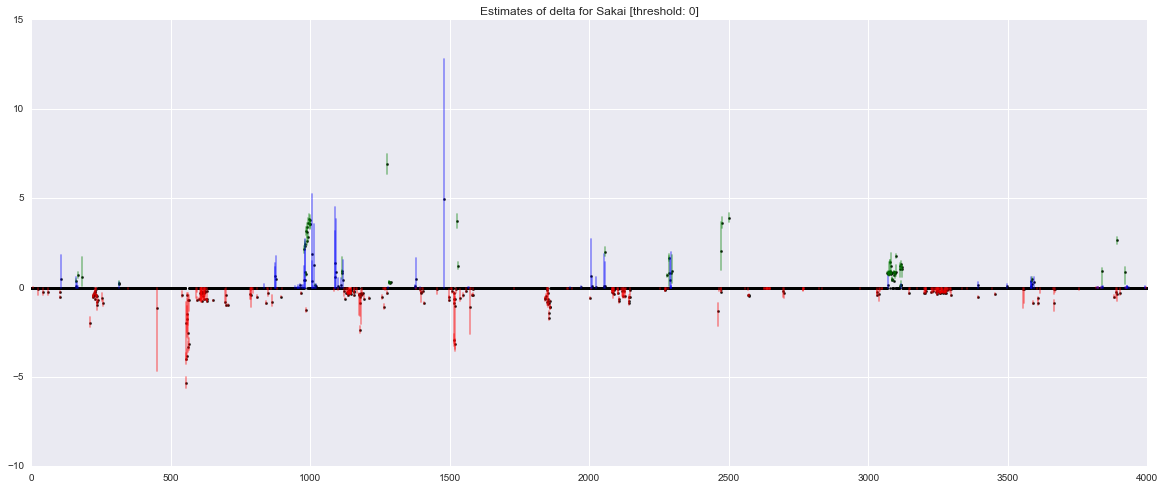

In [20]:
# Plot genome-wide estimates of delta for Sakai
tools.plot_parameter(sakai_estimates, 'd', 'Estimates of delta for Sakai')

These two plots indicate that most Sakai genes do not produce parameter estimates that are indicative of convincing effects in the control or treatment, in either direction.

Where effects are seen they tend to cluster on the genome, which is as would be expected if operons or gene clusters with common function were responsible for producing an effect. This is suggestive that we are measuring a real, biological effect.

In general, several clusters of both positive and negative effects appear in both plots for effects due to control ($\beta$) and treatment ($\delta$). However, two groups of locus tags - at approximately 1000 units and 2500 units on the $x$-axis - appear to be uniquely showing positive effects under the treatment condition,

#### DH10B

We plot similar representations for the DH10B isolate as a control, and see that all parameter estimates for this isolate's locus tags are very similar.

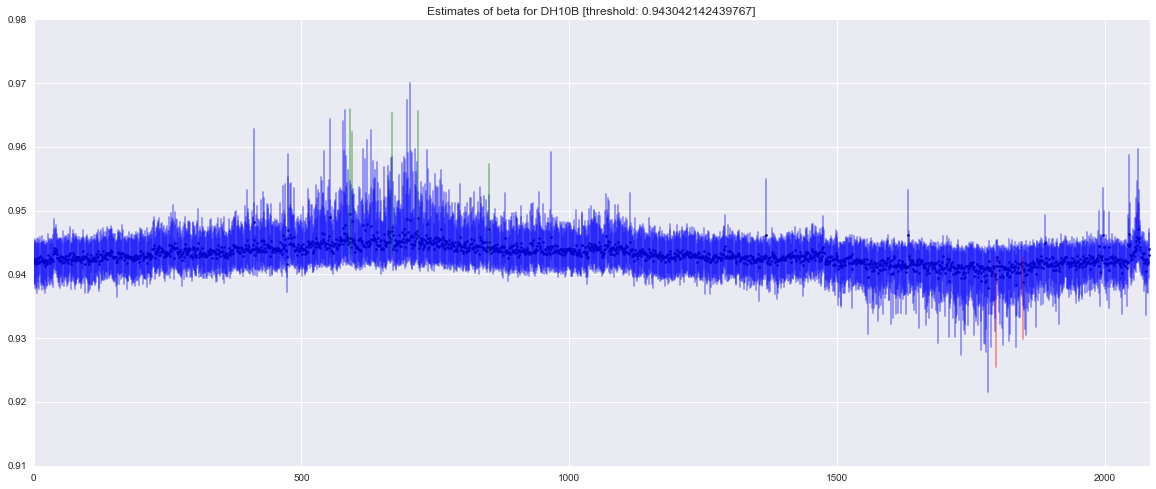

In [21]:
# Plot genome-wide estimates of beta for DH10B
beta_thresh = np.median(dh10b_estimates['b_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(dh10b_estimates, 'b', 'Estimates of beta for DH10B', beta_thresh)

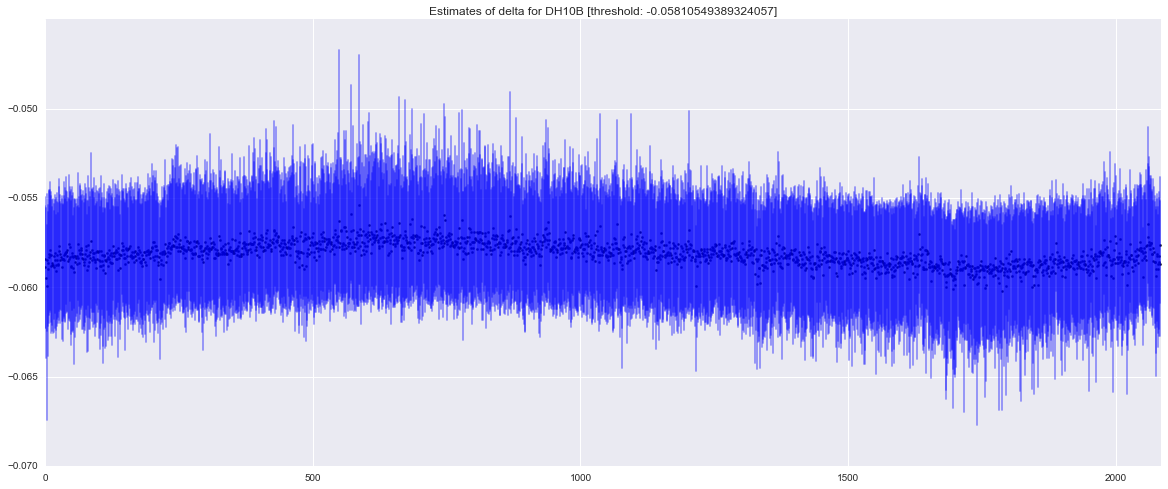

In [22]:
# Plot genome-wide estimates of delta for Sakai
delta_thresh = np.median(dh10b_estimates['d_median'])  # mark values that don't include the median delta in 50% CI
tools.plot_parameter(dh10b_estimates, 'd', 'Estimates of delta for DH10B', delta_thresh)

### Identifying candidates

With the information above, we can list the genes/locus tags that appear to have a positive effect on either the control or treatment steps.

In [23]:
candidates = sakai_estimates[sakai_estimates['ctl_pos'] | sakai_estimates['trt_pos']]
candidates = candidates[['locus_tag', 'b_median', 'ctl_pos', 'd_median', 'trt_pos']].sort_values(['ctl_pos', 'trt_pos', 'locus_tag'])

In [24]:
candidates.loc[candidates['trt_pos'] & ~candidates['ctl_pos']]

,locus_tag,b_median,ctl_pos,d_median,trt_pos
4460,ECs0237,1.173647,False,0.547856,True
3522,ECs0416,0.941709,False,0.240353,True
1264,ECs1350,0.941558,False,2.114064,True
1053,ECs1351,0.940556,False,2.397701,True
1051,ECs1352,0.940823,False,2.317902,True
1027,ECs1356,0.941057,False,3.149256,True
1009,ECs1360,0.940416,False,3.388202,True
1001,ECs1362,0.941461,False,3.079674,True
993,ECs1364,0.941854,False,2.597472,True
983,ECs1366,0.942249,False,3.596603,True


In [25]:
candidates.loc[candidates['trt_pos'] & ~candidates['ctl_pos']].shape

(48, 5)